<a href="https://colab.research.google.com/github/goddess1992/federated_new/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installations:

In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.141 🚀 Python-3.10.6 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.3/107.7 GB disk)


In [ ]:
# Run inference on an image with YOLOv8n
!yolo predict model=yolov8n.pt source='https://ultralytics.com/images/zidane.jpg'

In [ ]:
# Download COCO val
import torch
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')  # download (780M - 5000 images)
!unzip -q tmp.zip -d datasets && rm tmp.zip  # unzip

  0%|          | 0.00/780M [00:00<?, ?B/s]

replace datasets/coco/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace datasets/coco/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# Validate YOLOv8n on COCO128 val
!yolo val model=yolov8n.pt data=coco128.yaml

val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100% 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:42<00:00,  5.34s/it]


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='coco128.yaml', epochs=3)  # train the model
results = model.val()  # evaluate model performance on the validation set
results = model('https://ultralytics.com/images/bus.jpg')  # predict on an image
results = model.export(format='onnx')  # export the model to ONNX format

In [ ]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]

In [ ]:
# you might see a warning after running the command below, this can be ignored
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install matplotlib

In [ ]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST


def get_mnist(data_path: str = './data'):
    '''This function downloads the MNIST dataset into the `data_path`
    directory if it is not there already. WE construct the train/test
    split by converting the images into tensors and normalising them'''

    # transformation to conver images to tensors and apply normailsation
    tr = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # prepare train and test set
    trainset = MNIST(data_path, train=True, download=True, transform=tr)
    testset = MNIST(data_path, train=False, download=True, transform=tr)

    return trainset, testset

In [ ]:
trainset, testset = get_mnist()

In [ ]:
trainset

In [ ]:
import matplotlib.pyplot as plt


# construct histogram
all_labels = trainset.targets
num_possible_labels = len(set(all_labels.numpy().tolist())) # this counst unique labels (so it should be = 10)
plt.hist(all_labels, bins=num_possible_labels)

# plot formatting
plt.xticks(range(num_possible_labels))
plt.grid()
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.title('Class labels distribution for MNIST')

In [ ]:
import random
import numpy as np

def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
  # take n examples at random
  idx =list(range(len(trainset_.data)))
  random.shuffle(idx)
  idx = idx[:n]
  if verbose:
    print(f"will display images with idx: {idx}")


  # construct canvas
  num_cols = 8
  num_rows = int(np.ceil(len(idx)/num_cols))
  fig, axs = plt.subplots(figsize=(16, num_rows*2), nrows=num_rows, ncols=num_cols)

  # display images on canvas
  for c_i, i in enumerate(idx):
    axs.flat[c_i].imshow(trainset_.data[i], cmap='gray')

will display images with idx: [45359, 59328, 54902, 50091, 24815, 34813, 47650, 15110, 12072, 38418, 42888, 28253, 20359, 36713, 29913, 8728, 53902, 48409, 18775, 46579, 989, 51503, 20748, 32148, 30441, 6054, 43571, 42904, 49827, 55066, 56929, 10884]


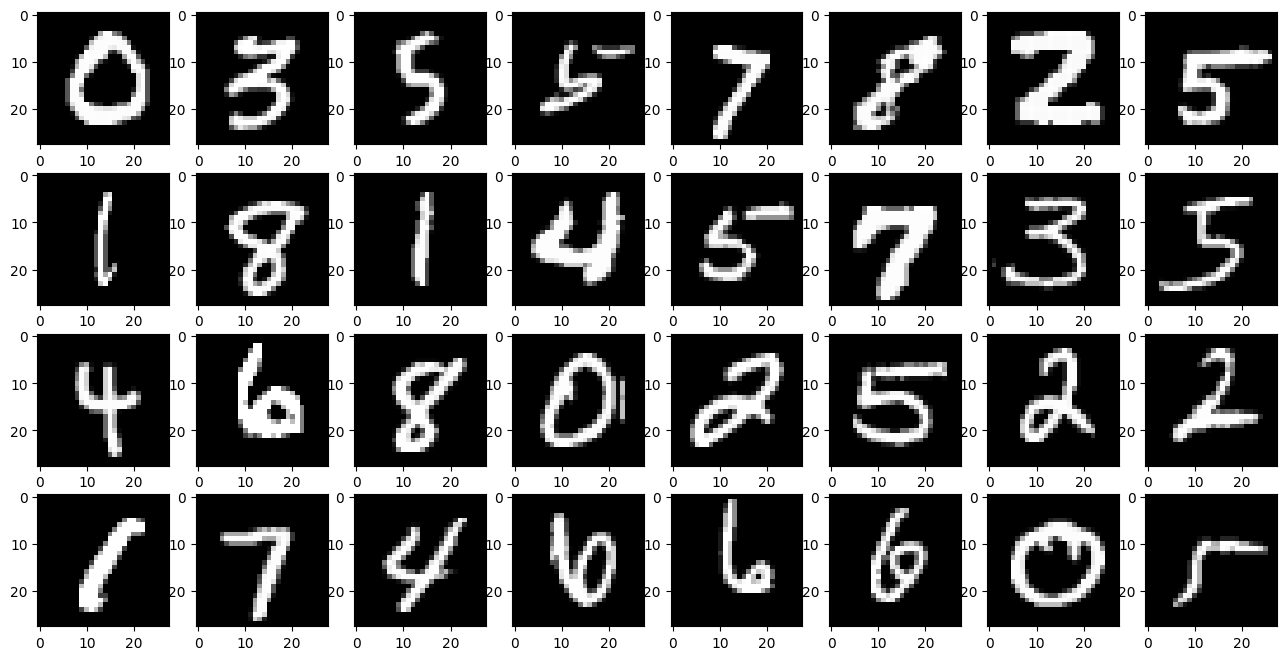

In [ ]:
# it is likely that the plot this function will generate looks familiar to other plots you might have generated before
# or you might have encountered in other tutorials. So far, we aren't doing anytning new, Federated Learning will start soon!
visualise_n_random_examples(trainset, n=32)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


In [ ]:
def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
    return net

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(epochs: int, lr: float, momentum: float=0.9):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # get dataset and construct a dataloaders
    trainset, testset = get_mnist()
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128)

    # train for the specified number of epochs
    trained_model = train(model, trainloader, optim, epochs)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

Let's run this for 5 epochs (you'll see it reaching close to 99% accuracy -- as expected from a centralised setup with the MNIST dataset)

In [ ]:
run_centralised(epochs=5, lr=0.01)

loss = 2.6855592668507597
accuracy = 0.9891


In [ ]:
from torch.utils.data import random_split

def prepare_dataset(num_partitions: int,
                    batch_size: int,
                    val_ratio: float = 0.1):

    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each traininsetg partition
    into train and validation. The test set is left intact and will
    be used by the central server to asses the performance of the
    global model. """

    # get the MNIST datatset
    trainset, testset = get_mnist()

    # split trainset into `num_partitions` trainsets
    num_images = len(trainset) // num_partitions

    partition_len = [num_images] * num_partitions

    trainsets = random_split(trainset, partition_len, torch.Generator().manual_seed(2023))

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(trainset_, [num_train, num_val], torch.Generator().manual_seed(2023))

        trainloaders.append(DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2))
        valloaders.append(DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=2))

    # create dataloader for the test set
    testloader = DataLoader(testset, batch_size=128)

    return trainloaders, valloaders, testloader

number of images: 540


Text(0.5, 1.0, 'Class labels distribution for MNIST')

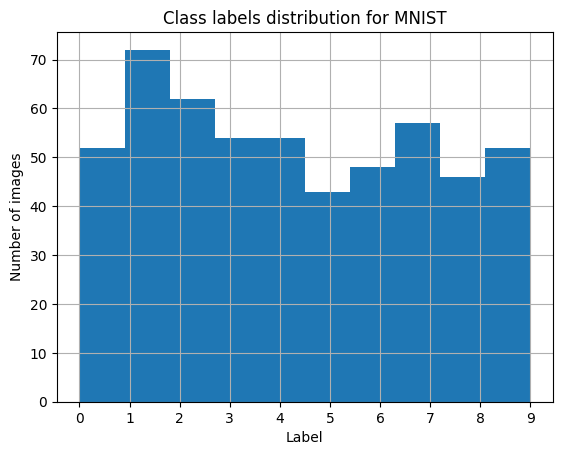

In [ ]:
trainloaders, valloaders, testloader = prepare_dataset(num_partitions=100,
                                                       batch_size=32)

# first partition
train_partition = trainloaders[0].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of images: {len(partition_indices)}")

# visualise histogram
plt.hist(train_partition.dataset.dataset.targets[partition_indices], bins=10)
plt.grid()
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.title('Class labels distribution for MNIST')

In [ ]:
import flwr as fl

Now let's defice our Flower Client class:

In [ ]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar

class FlowerClient(fl.client.NumPyClient):
    def __init__(self,
                 trainloader,
                 vallodaer) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = vallodaer
        self.model = Net(num_classes=10)

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentaillly the same as in the centralised example above
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training  -------------------------------------------------------------- Essentaillly the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train(self.model, self.trainloader, optim, epochs=1)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader) # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        # send statistics back to the server
        return float(loss), len(self.valloader), {'accuracy': accuracy}

In [ ]:
def get_evalulate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be exectued by the strategy
    at the end of each round to evaluate the stat of the global
    model."""
    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net(num_classes=10)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(model, testloader) # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn


# now we can define the strategy
strategy = fl.server.strategy.FedAvg(fraction_fit=0.1, # let's sample 10% of the client each round to do local training
                                      fraction_evaluate=0.1, # after each round, let's sample 20% of the clients to asses how well the global model is doing
                                      min_available_clients=100, # total number of clients available in the experiment
                                      evaluate_fn=get_evalulate_fn(testloader)) # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset


In [ ]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(trainloader=trainloaders[int(cid)],
                            vallodaer=valloaders[int(cid)])
    return client_fn

client_fn_callback = generate_client_fn(trainloaders, valloaders)

In [ ]:
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback, # a callback to construct a client
    num_clients=100, # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10), # let's run for 10 rounds
    strategy=strategy, # the strategy that will orchestrate the whole FL pipeline
)

INFO flwr 2023-07-25 06:22:54,653 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-07-25 06:23:00,424	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-07-25 06:23:02,454 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7866369639.0, 'object_store_memory': 3933184819.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7866369639.0, 'object_store_memory': 3933184819.0}
INFO flwr 2023-07-25 06:23:02,468 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-25 06:23:02,472 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random clien

history.metrics_centralized = {'accuracy': [(0, 0.1077), (1, 0.1293), (2, 0.1663), (3, 0.3916), (4, 0.4385), (5, 0.6111), (6, 0.8017), (7, 0.8404), (8, 0.8794), (9, 0.897), (10, 0.9028)]}


Text(0.5, 1.0, 'MNIST - IID - 100 clients with 10 clients per round')

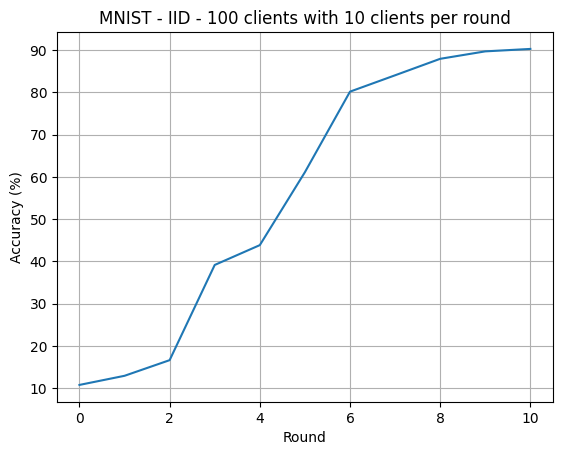

In [ ]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized['accuracy']
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0*data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel('Accuracy (%)')
plt.xlabel('Round')
plt.title('MNIST - IID - 100 clients with 10 clients per round')